In [ ]:
!pip install pyradiomics tensorflow_addons

In [ ]:
import matplotlib.pyplot as plt # plotting
import pandas as pd # DB
from radiomics import featureextractor
import nibabel as nib
import os
import glob
import numpy as np
from shutil import copyfile, copytree
import pickle

import tensorflow as tf

from sklearn.model_selection import train_test_split

from tensorflow import keras # residual unet architecture
from tensorflow.keras import optimizers # defining the optimizer

from keras import backend as K # seg-net layers
from keras.layers import Layer 

import tensorflow_addons as tfa # seg-net architecture
from keras.layers import Input, Activation, Reshape, BatchNormalization
from keras.models import Model
from keras.layers.convolutional import Convolution2D 


# Creating Pickle Variables

In [ ]:
import gdown

!gdown "19jGXLL7L67U2BhXT-8ZSHMWpJdlAZkfO&confirm=True"

import zipfile
with zipfile.ZipFile("brats.zip", 'r') as zip_ref:
    zip_ref.extractall("")

Downloading...
From: https://drive.google.com/uc?id=19jGXLL7L67U2BhXT-8ZSHMWpJdlAZkfO&confirm=True
To: /content/brats.zip
100% 5.49G/5.49G [01:10<00:00, 77.6MB/s]


In [ ]:
files = []

for root in os.listdir("content/GBM"):
  files.append(os.path.join("content/GBM",root))

for root in os.listdir("content/LGG"):
  files.append(os.path.join("content/LGG",root))

Magnetic Resonance Imaging (MRI) is commonly used imaging techniques for capturing images of brain tumors.By conﬁguring the MRI scanner diﬀerent modalities can be captured, such as T1-weighted (T1), T1-Post contrast-enhanced (T1ce), T2-weighted (T2), and T2-weighted ﬂuid-attenuated inversion recovery (Flair). T1 is good for seg-mentation of tumor from healthy brain tissue. T1ce has higher visibility of the tumor boundaries. In T2 the edema(ﬂuid) around the brain tumor is visible. And the Flair is suitable for identifying edema region from cerebrospinalﬂuid [3]. The MRI images can be viewed in three dimensions (Sagittal, Axial, and Coronal), which helps the medicalexperts in examining the tumors [4]. Enhancing tumor shows hyper-intensity mostly in T1-weighted. 

In [ ]:
channels = ["t1","t1ce","t2","flair"]

nPat = 50
nChan = len(channels)

In [ ]:
import random
random.seed(12345)
random.shuffle(files)

In [ ]:
for path in files:
  count = len(os.listdir(path))
  if count < 5:
    print(path)

In [ ]:
immV = np.zeros((nPat,120,120,77,nChan),dtype=np.float32)
segV = np.zeros((nPat,120,120,77,1),dtype=np.float32)

In [ ]:
for id,filepath in enumerate(files[:nPat]):
    for x, channel in enumerate(channels):
        head = nib.load(os.path.join(filepath,str(channel + ".nii.gz")))
        temp = head.get_fdata(dtype=np.float32)
        temp = temp[:,:,1:].reshape((2,120,2,120,2,77),order='F')
        immV[id,:,:,:,x] = np.mean(np.mean(np.mean(temp,axis=-2),axis=-3),axis=0)
    head = nib.load(os.path.join(filepath, "truth.nii.gz"))
    temp = head.get_fdata(dtype=np.float32)
    temp = temp[:,:,1:].reshape((2,120,2,120,2,77),order='F') 
    segV[id,:,:,:,0]= np.max(np.max(np.max(temp,axis=-2),axis=-3),axis=0)

In [ ]:
rnge = np.zeros((immV.shape[0],nChan),dtype=np.float32)
for sub in range(immV.shape[0]):
  for chan in range(nChan):
    temp = np.squeeze(immV[sub,:,:,:,chan])
    soglia = np.percentile(temp,1)
    rnge[sub,chan]=np.percentile(temp[temp>soglia],50)
rnge = rnge.reshape((immV.shape[0],1,1,1,nChan))   
immV = (immV-0.5*rnge)/rnge

(-0.5, 76.5, 119.5, -0.5)

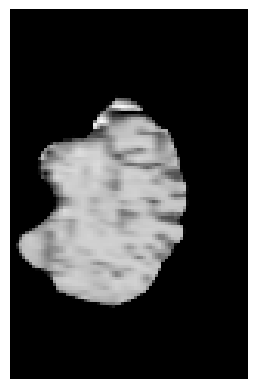

In [ ]:
plt.figure()
plt.imshow(immV[2,35,:,:,0],vmin=-0.3,vmax=1.0,cmap='Greys_r')
plt.contour(segV[2,35,:,:,0],[0.5,1.5,2.5])
plt.axis('off')

In [ ]:
# Open a file and use dump()
with open('immV.pkl', 'wb') as file:     
    # A new file will be created
    pickle.dump(immV, file)

In [ ]:
# Delete variables to save memory
del immV
del rnge

In [ ]:
with open('segV.pkl', 'wb') as file: 
    # A new file will be created
    pickle.dump(segV, file)

In [ ]:
del segV

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
copyfile("immV.pkl","drive/MyDrive/immV.pkl")
copyfile("segV.pkl","drive/MyDrive/segV.pkl")

'drive/MyDrive/segV.pkl'

# Import datasets

In [ ]:
!gdown 1SlHAQdHZlaAB41ywVnoYa9yOr51myE5w&confirm=t
!gdown 16DlqnS2j11Tls09M8HgVOPsn6BRNVqP8&confirm=t

Downloading...
From: https://drive.google.com/uc?id=1SlHAQdHZlaAB41ywVnoYa9yOr51myE5w
To: /content/immV.pkl
100% 887M/887M [00:06<00:00, 134MB/s]
Downloading...
From: https://drive.google.com/uc?id=16DlqnS2j11Tls09M8HgVOPsn6BRNVqP8
To: /content/segV.pkl
100% 222M/222M [00:02<00:00, 85.0MB/s]


In [ ]:
# Open the file in binary mode
with open('immV.pkl', 'rb') as file:
      
    # Call load method to deserialze
    immV = pickle.load(file)

with open('segV.pkl', 'rb') as file:
      
    # Call load method to deserialze
    segV = pickle.load(file)

Set how many patients we want to analyze

In [ ]:
nChan = 4

lowRam = 50

zeros = np.zeros((lowRam,128,128,77,nChan),dtype=np.float32)
mask = np.zeros((lowRam,128,128,77,1),dtype=np.float32)

minimo = immV.min()

zeros = np.clip(zeros, minimo,minimo)

zeros[:,:120,:120,:,:] = immV[:lowRam]
del immV
mask[:,:120,:120,:,:] = segV[:lowRam]
del segV

mask[mask>3.5]=3
mask = tf.keras.utils.to_categorical(mask)

### Flattening 3D images in stacks of 2D images. 

We will divide training and test patients before it, not to create cross-contamination between train and test.

Then we will treat all "slices" as independent samples.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(zeros, mask, test_size=0.33, random_state=42)

In [ ]:
# Delete variables to save memory
del zeros
del mask

In [ ]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(33, 128, 128, 77, 4)
(33, 128, 128, 77, 4)
(17, 128, 128, 77, 4)
(17, 128, 128, 77, 4)


In [ ]:
X_train = X_train.transpose((0,3,1,2,4))
X_train = X_train.reshape((-1,128,128,4))
y_train = y_train.transpose((0,3,1,2,4))
y_train = y_train.reshape((-1,128,128,4))

X_test = X_test.transpose((0,3,1,2,4))
X_test = X_test.reshape((-1,128,128,4))
y_test = y_test.transpose((0,3,1,2,4))
y_test = y_test.reshape((-1,128,128,4))

In [ ]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(2541, 128, 128, 4)
(2541, 128, 128, 4)
(1309, 128, 128, 4)
(1309, 128, 128, 4)


# Residual unet

## Architecture

In [ ]:
def bn_act(x, act=True):
    x = keras.layers.BatchNormalization()(x)
    if act == True:
        x = keras.layers.ReLU()(x)
    return x

def conv_block(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    conv = bn_act(x)
    conv = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides)(conv)
    return conv

def stem(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    conv = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides)(x)
    conv = conv_block(conv, filters, kernel_size=kernel_size, padding=padding, strides=strides)

    shortcut = keras.layers.Conv2D(filters, kernel_size=(1, 1), padding=padding, strides=strides)(x)
    shortcut = bn_act(shortcut, act=False)

    output = keras.layers.Add()([conv, shortcut])
    return output

def residual_block(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    res = conv_block(x, filters, kernel_size=kernel_size, padding=padding, strides=strides)
    res = conv_block(res, filters, kernel_size=kernel_size, padding=padding, strides=1)

    shortcut = keras.layers.Conv2D(filters, kernel_size=(1, 1), padding=padding, strides=strides)(x)
    shortcut = bn_act(shortcut, act=False)

    output = keras.layers.Add()([shortcut, res])
    return output

def upsample_concat_block(x, xskip):
    u = keras.layers.UpSampling2D((2, 2))(x)
    c = keras.layers.Concatenate()([u, xskip])
    return c

In [ ]:
f = [16, 32, 64, 128, 256]
inputs = keras.layers.Input((128, 128, 4))

## Encoder
e0 = inputs
e1 = stem(e0, f[0])
e2 = residual_block(e1, f[1], strides=2)
e3 = residual_block(e2, f[2], strides=2)
e4 = residual_block(e3, f[3], strides=2)
e5 = residual_block(e4, f[4], strides=2)

## Bridge
b0 = conv_block(e5, f[4], strides=1)
b1 = conv_block(b0, f[4], strides=1)

## Decoder
u1 = upsample_concat_block(b1, e4)
d1 = residual_block(u1, f[4])

u2 = upsample_concat_block(d1, e3)
d2 = residual_block(u2, f[3])

u3 = upsample_concat_block(d2, e2)
d3 = residual_block(u3, f[2])

u4 = upsample_concat_block(d3, e1)
d4 = residual_block(u4, f[1])

outputs = keras.layers.Conv2D(4, (1, 1), padding="same", activation="sigmoid")(d4)
model = keras.models.Model(inputs, outputs)

### Define the "dice coef" and "dice_coef_loss"

In [ ]:
smooth = 1.

def dice_coef(y_true, y_pred):
    y_true_f = tf.compat.v1.layers.flatten(y_true)
    y_pred_f = tf.compat.v1.layers.flatten(y_pred)
    intersection = tf.math.reduce_sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.math.reduce_sum(y_true_f) + tf.math.reduce_sum(y_pred_f) + smooth)

def dice_coef_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

### Define the optimizer and compile the model

> Blocco con rientro



In [ ]:
adam = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=adam, loss="categorical_crossentropy", metrics=[dice_coef])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 4  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_30 (Conv2D)             (None, 128, 128, 16  592         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_28 (BatchN  (None, 128, 128, 16  64         ['conv2d_30[0][0]']              
 ormalization)                  )                                                           

In [ ]:
X_train.shape

(2541, 128, 128, 4)

In [ ]:
X_test.shape

(1309, 128, 128, 4)

### Fit the model

In [ ]:
batch_size=11

valid_ids = X_test.shape[0]
train_ids = X_train.shape[0]

train_steps = train_ids//batch_size
valid_steps = valid_ids//batch_size

epochs = 30

history = model.fit(X_train, y_train, validation_data=(X_test,y_test), steps_per_epoch=train_steps, validation_steps=valid_steps, 
                    epochs=epochs)

Epoch 1/30


/usr/local/lib/python3.10/dist-packages/tensorflow/python/autograph/impl/api.py:459: UserWarning: `tf.layers.flatten` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Flatten` instead.
  return f(*args)
/usr/local/lib/python3.10/dist-packages/keras/legacy_tf_layers/base.py:627: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  self.updates, tf.compat.v1.GraphKeys.UPDATE_OPS


231/231 [==============================] - 43s 99ms/step - loss: 0.1363 - dice_coef: 0.8637 - val_loss: 0.0156 - val_dice_coef: 0.9844
Epoch 2/30
231/231 [==============================] - 23s 99ms/step - loss: 0.0110 - dice_coef: 0.9890 - val_loss: 0.0084 - val_dice_coef: 0.9916
Epoch 3/30
231/231 [==============================] - 23s 98ms/step - loss: 0.0074 - dice_coef: 0.9926 - val_loss: 0.0064 - val_dice_coef: 0.9936
Epoch 4/30
231/231 [==============================] - 23s 98ms/step - loss: 0.0058 - dice_coef: 0.9942 - val_loss: 0.0060 - val_dice_coef: 0.9940
Epoch 5/30
231/231 [==============================] - 23s 98ms/step - loss: 0.0050 - dice_coef: 0.9950 - val_loss: 0.0057 - val_dice_coef: 0.9943
Epoch 6/30
231/231 [==============================] - 20s 89ms/step - loss: 0.0045 - dice_coef: 0.9955 - val_loss: 0.0054 - val_dice_coef: 0.9946
Epoch 7/30
231/231 [==============================] - 20s 87ms/step - loss: 0.0042 - dice_coef: 0.9958 - val_loss: 0.0054 - val_dice_co

In [ ]:
pd.DataFrame.from_dict(history.history).to_csv("Resunet.csv")

## Compute DICE scores in BRATS categories:

In [ ]:
def diceFromMap(map1,map2):
    unionLab = np.sum(map1) +np.sum(map2)
    interLab = np.sum(map1 & map2, dtype=np.float32)
    return (2*interLab+.1)/(unionLab+.1)
def computeDices (yPred,yTrue):
    yPred = np.asarray(yPred)
    yTrue = np.asarray(yTrue)
    if np.sum(yTrue[:,:,:,1:])<1:
        return(np.nan,np.nan,np.nan)
    diceWhole = diceFromMap(np.sum(yPred[:,:,:,1:],axis=-1)>np.sum(yPred[:,:,:,:1],axis=-1),
                            np.sum(yTrue[:,:,:,1:],axis=-1)>np.sum(yTrue[:,:,:,:1],axis=-1))
    diceCore = diceFromMap(np.sum(yPred[:,:,:,2:],axis=-1)>np.sum(yPred[:,:,:,:2],axis=-1),
                           np.sum(yTrue[:,:,:,2:],axis=-1)>np.sum(yTrue[:,:,:,:2],axis=-1))
    diceEnh = diceFromMap(np.sum(yPred[:,:,:,3:],axis=-1)>np.sum(yPred[:,:,:,:3],axis=-1),
                          np.sum(yTrue[:,:,:,3:],axis=-1)>np.sum(yTrue[:,:,:,:3],axis=-1))
    return (diceWhole,diceCore,diceEnh)

In [ ]:
nTestPat = 17
diceV = np.zeros((17,3))
for idx in range(17):
    yPred = model(X_test[idx*77:(idx+1)*77,:,:,:])
    diceV[idx,:]=np.array(computeDices(yPred,y_test[idx*77:(idx+1)*77,:,:,:]))

Whole Dice: mean = 82.2% Median = 85.5%
Core Dice: mean = 76.6% Median = 84.0%
Active Dice: mean = 54.6% Median = 59.0%


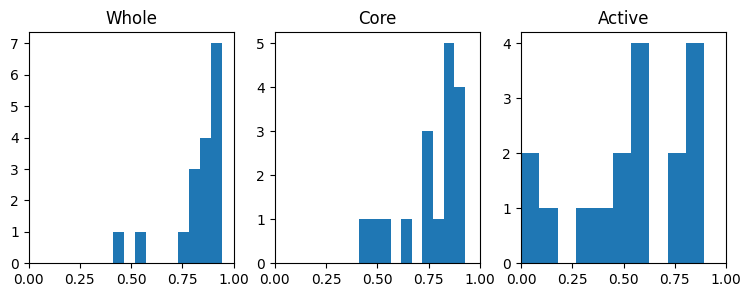

In [ ]:
plt.figure(figsize=(9,3))
titleList = ['Whole','Core','Active']
for i in range(3):
    plt.subplot(1,3,i+1)
    _=plt.hist(diceV[:,i])
    plt.xlim(0,1)
    plt.title(titleList[i])
for i in range(3):
    outStr = titleList[i] + ' Dice: mean = {:.1f}% Median = {:.1f}%'    
    print(outStr.format(np.mean(diceV[:,i]*100),np.median(diceV[:,i]*100)))

## Display the segmentation of 1 patient

3/3 [==============================] - 4s 690ms/step


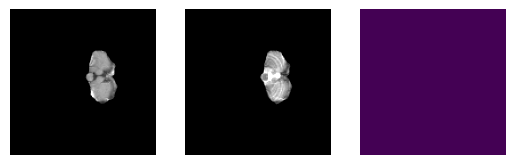

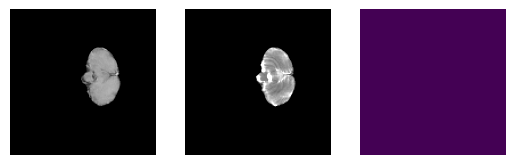

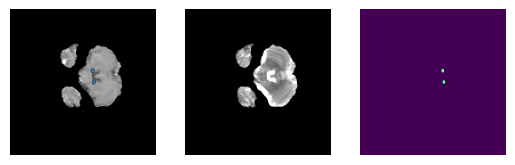

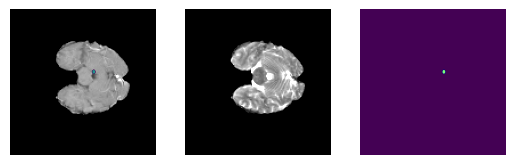

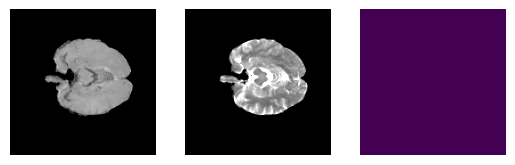

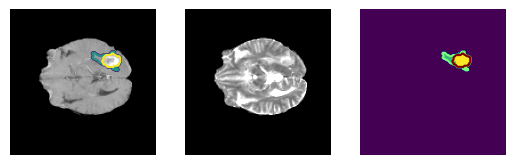

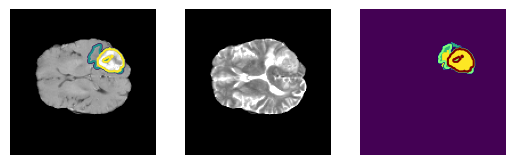

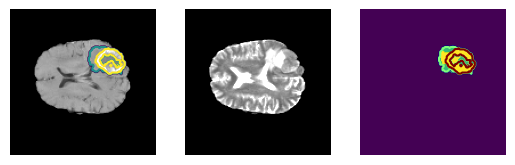

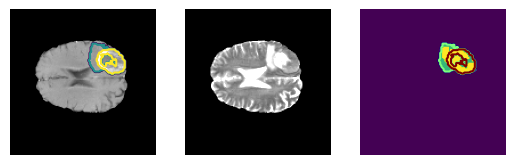

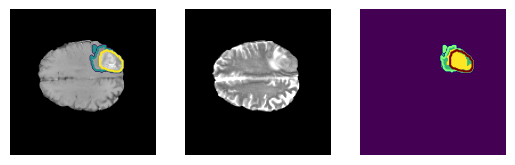

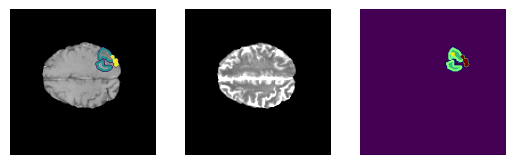

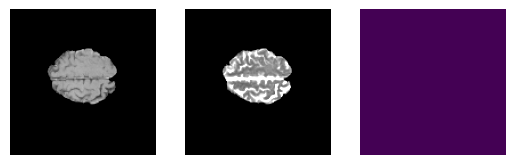

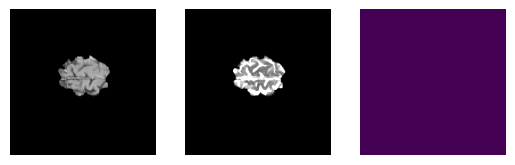

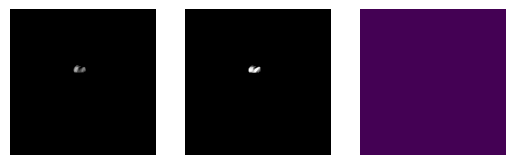

In [ ]:
patIdx = 2
slStart = 3
slStop = 70
slStep = 5

yPred = np.array(model.predict(X_test[(patIdx*77):((patIdx+1)*77),:,:,:]))
yPred = np.argmax(yPred,axis=-1)
yTrue = y_test[(patIdx*77):((patIdx+1)*77),:,:,:]
yTrue = np.argmax(yTrue,axis=-1)
for slIdx in range(slStart,slStop,slStep):
    plt.figure()
    plt.subplot(131)
    plt.imshow(X_test[patIdx*77+slIdx,:,:,1],vmin=-0.3,vmax=1.0,cmap='gray')
    plt.contour(yTrue[slIdx,:,:],[0.5,1.5,2.5])
    plt.axis('off')
    plt.subplot(132)
    plt.imshow(X_test[patIdx*77+slIdx,:,:,2],vmin=-0.3,vmax=1.0,cmap='gray')
    plt.axis('off')
  #  plt.contour(yTrue[slIdx,:,:],[0.5,1.5,2.5])
    plt.subplot(133)
    plt.imshow(yPred[slIdx,:,:],vmin=0,vmax=3)
    plt.contour(yTrue[slIdx,:,:],[0.5,1.5,2.5],cmap='jet')    
    plt.axis('off')

Saving the model

In [ ]:
model.save("ResUNet.h5")

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
!cp ResUNet.h5 drive/MyDrive/ResUNet.h5

# Seg-Net 

## Architecture


In [ ]:
class MaxPoolingWithArgmax2D(Layer):
    def __init__(self, pool_size=(2, 2), strides=(2, 2), padding="same", **kwargs):
        super(MaxPoolingWithArgmax2D, self).__init__(**kwargs)
        self.padding = padding
        self.pool_size = pool_size
        self.strides = strides

    def call(self, inputs, **kwargs):
        padding = self.padding
        pool_size = self.pool_size
        strides = self.strides
        if K.backend() == "tensorflow":
            ksize = [1, pool_size[0], pool_size[1], 1]
            padding = padding.upper()
            strides = [1, strides[0], strides[1], 1]
            output, argmax = K.tf.nn.max_pool_with_argmax(
                inputs, ksize=ksize, strides=strides, padding=padding
            )
        else:
            errmsg = "{} backend is not supported for layer {}".format(
                K.backend(), type(self).__name__
            )
            raise NotImplementedError(errmsg)
        argmax = K.cast(argmax, K.floatx())
        return [output, argmax]

    def compute_output_shape(self, input_shape):
        ratio = (1, 2, 2, 1)
        output_shape = [
            dim // ratio[idx] if dim is not None else None
            for idx, dim in enumerate(input_shape)
        ]
        output_shape = tuple(output_shape)
        return [output_shape, output_shape]

    def compute_mask(self, inputs, mask=None):
        return 2 * [None]


class MaxUnpooling2D(Layer):
    def __init__(self, size=(2, 2), **kwargs):
        super(MaxUnpooling2D, self).__init__(**kwargs)
        self.size = size

    def call(self, inputs, output_shape=None):
        updates, mask = inputs[0], inputs[1]
        with K.tf.compat.v1.variable_scope(self.name):
            mask = K.cast(mask, "int32")
            input_shape = K.tf.shape(updates, out_type="int32")
            #  calculation new shape
            if output_shape is None:
                output_shape = (
                    input_shape[0],
                    input_shape[1] * self.size[0],
                    input_shape[2] * self.size[1],
                    input_shape[3],
                )
            self.output_shape1 = output_shape

            # calculation indices for batch, height, width and feature maps
            one_like_mask = K.ones_like(mask, dtype="int32")
            batch_shape = K.concatenate([[input_shape[0]], [1], [1], [1]], axis=0)
            batch_range = K.reshape(
                K.tf.range(output_shape[0], dtype="int32"), shape=batch_shape
            )
            b = one_like_mask * batch_range
            y = mask // (output_shape[2] * output_shape[3])
            x = (mask // output_shape[3]) % output_shape[2]
            feature_range = K.tf.range(output_shape[3], dtype="int32")
            f = one_like_mask * feature_range

            # transpose indices & reshape update values to one dimension
            updates_size = K.tf.size(updates)
            indices = K.transpose(K.reshape(K.stack([b, y, x, f]), [4, updates_size]))
            values = K.reshape(updates, [updates_size])
            ret = K.tf.scatter_nd(indices, values, output_shape)
            return ret

    def compute_output_shape(self, input_shape):
        mask_shape = input_shape[1]
        return (
            mask_shape[0],
            mask_shape[1] * self.size[0],
            mask_shape[2] * self.size[1],
            mask_shape[3],
        )

In [ ]:
def segnet(input_shape, n_labels, kernel=3, pool_size=(2, 2), output_mode="softmax"):
    # encoder
    inputs = Input(input_shape, batch_size = 1)

    conv_1 = Convolution2D(64, (kernel, kernel), padding="same")(inputs)
    conv_1 = BatchNormalization()(conv_1)
    conv_1 = Activation("relu")(conv_1)
    conv_2 = Convolution2D(64, (kernel, kernel), padding="same")(conv_1)
    conv_2 = BatchNormalization()(conv_2)
    conv_2 = Activation("relu")(conv_2)

    pool_1, mask_1 = MaxPoolingWithArgmax2D(pool_size)(conv_2)

    conv_3 = Convolution2D(128, (kernel, kernel), padding="same")(pool_1)
    conv_3 = BatchNormalization()(conv_3)
    conv_3 = Activation("relu")(conv_3)
    conv_4 = Convolution2D(128, (kernel, kernel), padding="same")(conv_3)
    conv_4 = BatchNormalization()(conv_4)
    conv_4 = Activation("relu")(conv_4)

    pool_2, mask_2 = MaxPoolingWithArgmax2D(pool_size)(conv_4)

    conv_5 = Convolution2D(256, (kernel, kernel), padding="same")(pool_2)
    conv_5 = BatchNormalization()(conv_5)
    conv_5 = Activation("relu")(conv_5)
    conv_6 = Convolution2D(256, (kernel, kernel), padding="same")(conv_5)
    conv_6 = BatchNormalization()(conv_6)
    conv_6 = Activation("relu")(conv_6)
    conv_7 = Convolution2D(256, (kernel, kernel), padding="same")(conv_6)
    conv_7 = BatchNormalization()(conv_7)
    conv_7 = Activation("relu")(conv_7)

    pool_3, mask_3 = MaxPoolingWithArgmax2D(pool_size)(conv_7)

    conv_8 = Convolution2D(512, (kernel, kernel), padding="same")(pool_3)
    conv_8 = BatchNormalization()(conv_8)
    conv_8 = Activation("relu")(conv_8)
    conv_9 = Convolution2D(512, (kernel, kernel), padding="same")(conv_8)
    conv_9 = BatchNormalization()(conv_9)
    conv_9 = Activation("relu")(conv_9)
    conv_10 = Convolution2D(512, (kernel, kernel), padding="same")(conv_9)
    conv_10 = BatchNormalization()(conv_10)
    conv_10 = Activation("relu")(conv_10)

    pool_4, mask_4 = MaxPoolingWithArgmax2D(pool_size)(conv_10)

    conv_11 = Convolution2D(512, (kernel, kernel), padding="same")(pool_4)
    conv_11 = BatchNormalization()(conv_11)
    conv_11 = Activation("relu")(conv_11)
    conv_12 = Convolution2D(512, (kernel, kernel), padding="same")(conv_11)
    conv_12 = BatchNormalization()(conv_12)
    conv_12 = Activation("relu")(conv_12)
    conv_13 = Convolution2D(512, (kernel, kernel), padding="same")(conv_12)
    conv_13 = BatchNormalization()(conv_13)
    conv_13 = Activation("relu")(conv_13)

    pool_5, mask_5 = MaxPoolingWithArgmax2D(pool_size)(conv_13)
    print("Build enceder done..")

    # decoder

    unpool_1 = MaxUnpooling2D(pool_size)([pool_5, mask_5])

    conv_14 = Convolution2D(512, (kernel, kernel), padding="same")(unpool_1)
    conv_14 = BatchNormalization()(conv_14)
    conv_14 = Activation("relu")(conv_14)
    conv_15 = Convolution2D(512, (kernel, kernel), padding="same")(conv_14)
    conv_15 = BatchNormalization()(conv_15)
    conv_15 = Activation("relu")(conv_15)
    conv_16 = Convolution2D(512, (kernel, kernel), padding="same")(conv_15)
    conv_16 = BatchNormalization()(conv_16)
    conv_16 = Activation("relu")(conv_16)

    unpool_2 = MaxUnpooling2D(pool_size)([conv_16, mask_4])

    conv_17 = Convolution2D(512, (kernel, kernel), padding="same")(unpool_2)
    conv_17 = BatchNormalization()(conv_17)
    conv_17 = Activation("relu")(conv_17)
    conv_18 = Convolution2D(512, (kernel, kernel), padding="same")(conv_17)
    conv_18 = BatchNormalization()(conv_18)
    conv_18 = Activation("relu")(conv_18)
    conv_19 = Convolution2D(256, (kernel, kernel), padding="same")(conv_18)
    conv_19 = BatchNormalization()(conv_19)
    conv_19 = Activation("relu")(conv_19)

    unpool_3 = MaxUnpooling2D(pool_size)([conv_19, mask_3])

    conv_20 = Convolution2D(256, (kernel, kernel), padding="same")(unpool_3)
    conv_20 = BatchNormalization()(conv_20)
    conv_20 = Activation("relu")(conv_20)
    conv_21 = Convolution2D(256, (kernel, kernel), padding="same")(conv_20)
    conv_21 = BatchNormalization()(conv_21)
    conv_21 = Activation("relu")(conv_21)
    conv_22 = Convolution2D(128, (kernel, kernel), padding="same")(conv_21)
    conv_22 = BatchNormalization()(conv_22)
    conv_22 = Activation("relu")(conv_22)

    unpool_4 = MaxUnpooling2D(pool_size)([conv_22, mask_2])

    conv_23 = Convolution2D(128, (kernel, kernel), padding="same")(unpool_4)
    conv_23 = BatchNormalization()(conv_23)
    conv_23 = Activation("relu")(conv_23)
    conv_24 = Convolution2D(64, (kernel, kernel), padding="same")(conv_23)
    conv_24 = BatchNormalization()(conv_24)
    conv_24 = Activation("relu")(conv_24)

    unpool_5 = MaxUnpooling2D(pool_size)([conv_24, mask_1])

    conv_25 = Convolution2D(64, (kernel, kernel), padding="same")(unpool_5)
    conv_25 = BatchNormalization()(conv_25)
    conv_25 = Activation("relu")(conv_25)

    conv_26 = Convolution2D(n_labels, (1, 1), padding="valid")(conv_25)
    conv_26 = BatchNormalization()(conv_26)
    conv_26 = Reshape(
        (input_shape[0], input_shape[1], n_labels),
        input_shape=(input_shape[0], input_shape[1], n_labels),
    )(conv_26)

    outputs = Activation(output_mode)(conv_26)
    print("Build decoder done..")

    model = Model(inputs=inputs, outputs=outputs, name="SegNet")

    return model

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [ ]:
model = segnet([128, 128, 4], 4)

Build enceder done..
Build decoder done..


In [ ]:
model.summary()

Model: "SegNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(1, 128, 128, 4)]   0           []                               
                                                                                                  
 conv2d (Conv2D)                (1, 128, 128, 64)    2368        ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (1, 128, 128, 64)   256         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 activation (Activation)        (1, 128, 128, 64)    0           ['batch_normalization[0][0]'

### Define the optimizer and compile the model

In [ ]:
optim = optimizers.Adam(learning_rate=1e-3)
model.compile(loss="categorical_crossentropy", optimizer=optim, metrics= [dice_coef])

### Fit the model

In [ ]:
fitHist = model.fit(X_train,y_train,validation_data=(X_test,y_test), batch_size=14, epochs=30)

Epoch 1/30


/usr/local/lib/python3.10/dist-packages/tensorflow/python/autograph/impl/api.py:459: UserWarning: `tf.layers.flatten` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Flatten` instead.
  return f(*args)
/usr/local/lib/python3.10/dist-packages/keras/legacy_tf_layers/base.py:627: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  self.updates, tf.compat.v1.GraphKeys.UPDATE_OPS


182/182 [==============================] - 128s 566ms/step - loss: 0.5628 - dice_coef: 0.4373 - val_loss: 0.4930 - val_dice_coef: 0.5069
Epoch 2/30
182/182 [==============================] - 87s 480ms/step - loss: 0.4599 - dice_coef: 0.5402 - val_loss: 0.4264 - val_dice_coef: 0.5737
Epoch 3/30
182/182 [==============================] - 84s 463ms/step - loss: 0.3750 - dice_coef: 0.6251 - val_loss: 0.3463 - val_dice_coef: 0.6535
Epoch 4/30
182/182 [==============================] - 81s 448ms/step - loss: 0.3074 - dice_coef: 0.6927 - val_loss: 0.3407 - val_dice_coef: 0.6600
Epoch 5/30
182/182 [==============================] - 101s 558ms/step - loss: 0.2492 - dice_coef: 0.7509 - val_loss: 0.2366 - val_dice_coef: 0.7636
Epoch 6/30
182/182 [==============================] - 102s 563ms/step - loss: 0.2052 - dice_coef: 0.7948 - val_loss: 0.1759 - val_dice_coef: 0.8242
Epoch 7/30
182/182 [==============================] - 81s 444ms/step - loss: 0.1716 - dice_coef: 0.8284 - val_loss: 0.1751 - v

In [ ]:
pd.DataFrame.from_dict(fitHist.history).to_csv("Segnet.csv")

Saving the model

In [ ]:
model.save("EncDecSegNet.h5")

## Compute DICE scores in BRATS categories


In [ ]:
def diceFromMap(map1,map2):
    unionLab = np.sum(map1) +np.sum(map2)
    interLab = np.sum(map1 & map2, dtype=np.float32)
    return (2*interLab+.1)/(unionLab+.1)
def computeDices (yPred,yTrue):
    yPred = np.asarray(yPred)
    yTrue = np.asarray(yTrue)
    if np.sum(yTrue[:,:,:,1:])<1:
        return(np.nan,np.nan,np.nan)
    diceWhole = diceFromMap(np.sum(yPred[:,:,:,1:],axis=-1)>np.sum(yPred[:,:,:,:1],axis=-1),
                            np.sum(yTrue[:,:,:,1:],axis=-1)>np.sum(yTrue[:,:,:,:1],axis=-1))
    diceCore = diceFromMap(np.sum(yPred[:,:,:,2:],axis=-1)>np.sum(yPred[:,:,:,:2],axis=-1),
                           np.sum(yTrue[:,:,:,2:],axis=-1)>np.sum(yTrue[:,:,:,:2],axis=-1))
    diceEnh = diceFromMap(np.sum(yPred[:,:,:,3:],axis=-1)>np.sum(yPred[:,:,:,:3],axis=-1),
                          np.sum(yTrue[:,:,:,3:],axis=-1)>np.sum(yTrue[:,:,:,:3],axis=-1))
    return (diceWhole,diceCore,diceEnh)

In [ ]:
yPred.shape

(77, 128, 128)

In [ ]:
X_test.shape

(1309, 128, 128, 4)

In [ ]:
nTestPat = 1
diceV = np.zeros((10,3))
for idx in range(10):
    yPred = model(X_test[idx*77:(idx+1)*77])
    diceV[idx,:]=np.array(computeDices(yPred,y_test[idx*77:(idx+1)*77]))

In [ ]:
X_test.shape

(1309, 128, 128, 4)

Whole Dice: mean = 82.7% Median = 83.2%
Core Dice: mean = 72.7% Median = 73.9%
Active Dice: mean = 26.3% Median = 27.8%


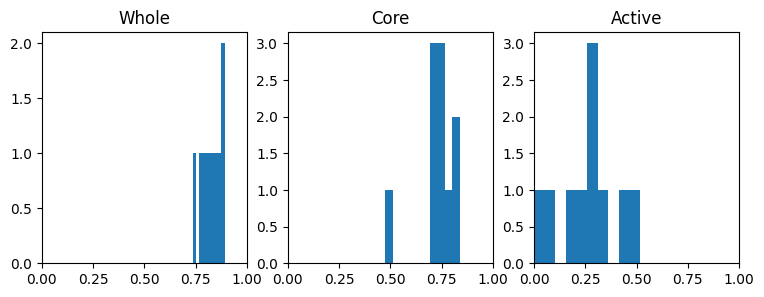

In [ ]:
plt.figure(figsize=(9,3))
titleList = ['Whole','Core','Active']
for i in range(3):
    plt.subplot(1,3,i+1)
    _=plt.hist(diceV[:,i])
    plt.xlim(0,1)
    plt.title(titleList[i])
for i in range(3):
    outStr = titleList[i] + ' Dice: mean = {:.1f}% Median = {:.1f}%'    
    print(outStr.format(np.mean(diceV[:,i]*100),np.median(diceV[:,i]*100)))

## Display the segmentation of 1 patient

Patient images

In [ ]:
model.load("EncDecSegNet.h5")

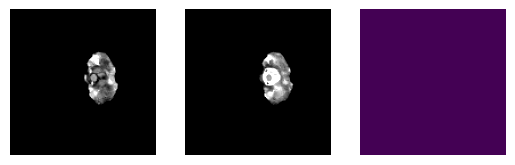

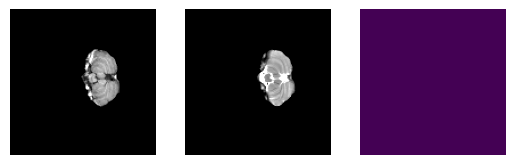

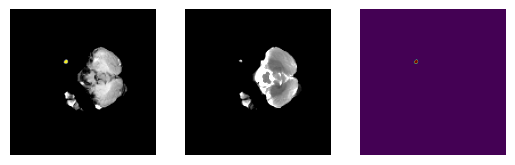

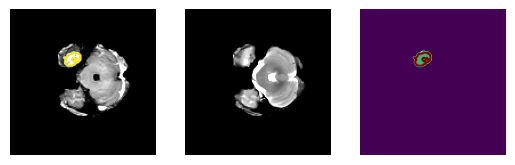

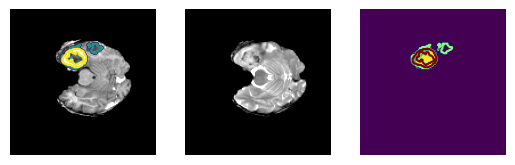

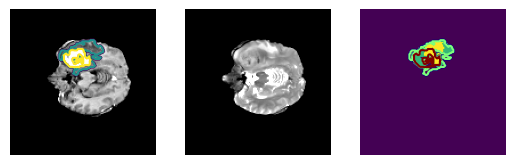

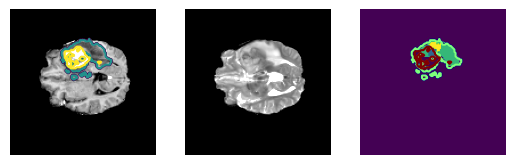

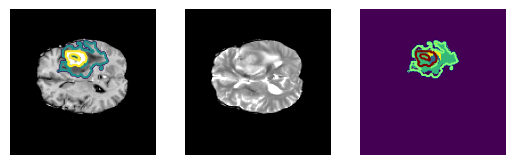

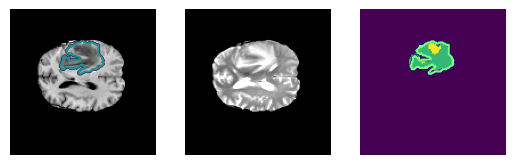

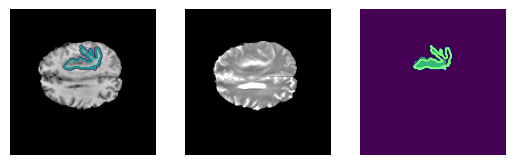

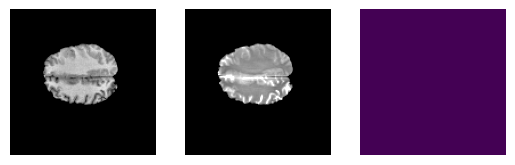

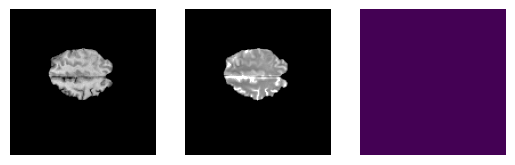

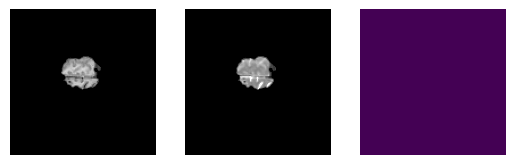

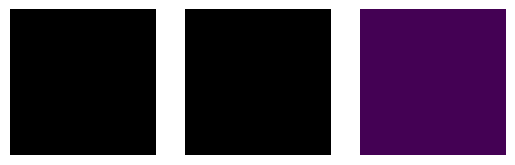

In [ ]:
patIdx = 1
slStart = 3
slStop = 70
slStep = 5

yPred = np.array(model(X_test[(patIdx*77):((patIdx+1)*77),:,:,:]))
yPred = np.argmax(yPred,axis=-1)
yTrue = y_test[(patIdx*77):((patIdx+1)*77),:,:,:]
yTrue = np.argmax(yTrue,axis=-1)
for slIdx in range(slStart,slStop,slStep):
    plt.figure()
    plt.subplot(131)
    plt.imshow(X_test[patIdx*77+slIdx,:,:,1],vmin=-0.3,vmax=1.0,cmap='gray')
    plt.contour(yTrue[slIdx,:,:],[0.5,1.5,2.5])
    plt.axis('off')
    plt.subplot(132)
    plt.imshow(X_test[patIdx*77+slIdx,:,:,2],vmin=-0.3,vmax=1.0,cmap='gray')
    plt.axis('off')
  #  plt.contour(yTrue[slIdx,:,:],[0.5,1.5,2.5])
    plt.subplot(133)
    plt.imshow(yPred[slIdx,:,:],vmin=0,vmax=3)
    plt.contour(yTrue[slIdx,:,:],[0.5,1.5,2.5],cmap='jet')    
    plt.axis('off')